In [13]:
import import_ipynb
import Model
import Dataset
import LightningModel
import DataModule

import lightning as L
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint

import pandas as pd
import time

# Hyperparameter Tuning

In [2]:
num_epochs = 50
lr = 0.1
trainer = L.Trainer(max_epochs=num_epochs,
                   devices="auto",
                   deterministic=True,
                   logger=CSVLogger(save_dir="./lightning_logs", name="simpson_mnist"))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Finding a good batch size

In [3]:
from lightning.pytorch.tuner import Tuner
tuner = Tuner(trainer)
L.pytorch.seed_everything(123)
model = Model.TorchModel(num_classes=10)
lightning_model = LightningModel.LightningModel(model=model, lr=lr)
datamodule = DataModule.DataModule()

Global seed set to 123


In [4]:
batch_size_finder = tuner.scale_batch_size(model=lightning_model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/onuraydemir/miniconda3/envs/remenv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/onuraydemir/miniconda3/envs/remenv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 2 succeeded, trying batch size 4
`Trainer.fit` stopped: `max_steps=

In [5]:
batch_size_finder

2048

### Finding a good learning rate

In [6]:
L.pytorch.seed_everything(123)
model = Model.TorchModel(num_classes=10)
lightning_model = LightningModel.LightningModel(model=model, lr=lr)
datamodule = DataModule.DataModule(batch_size=batch_size_finder)
lr_finder = tuner.lr_find(model=lightning_model, datamodule=datamodule, early_stop_threshold=100.0)

Global seed set to 123
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr: 100%|████████████████| 100/100 [03:28<00:00,  2.09s/it]
Learning rate set to 0.2290867652767775
Restoring states from the checkpoint path at /home/onuraydemir/Desktop/Code/Notebooks/.lr_find_fa3137f7-ae1c-4267-9c90-933219e6f5c2.ckpt
Restored all states from the checkpoint at /home/onuraydemir/Desktop/Code/Notebooks/.lr_find_fa3137f7-ae1c-4267-9c90-933219e6f5c2.ckpt


In [7]:
recommended_lr = lr if lr_finder.suggestion() is None else lr_finder.suggestion()
recommended_lr

0.2290867652767775

# Trying combination of other hyperparameters
- ex: sunum_deneme.py

# Accelerated Traning

### Mixed Precision Training

<img src="https://lightningaidev.wpengine.com/wp-content/uploads/2023/05/mp-training.png" width=1000 height=400>

In [8]:
L.pytorch.seed_everything(123)
model = Model.TorchModel(num_classes=10)
lightning_model = LightningModel.LightningModel(model=model, lr=recommended_lr)
trainer = L.Trainer(max_epochs=num_epochs,
                    devices="auto",
                    deterministic=True,
                    precision="16-mixed",
                    logger=CSVLogger(save_dir="./lightning_logs", name="simpson_mnist"))
datamodule = DataModule.DataModule(batch_size=batch_size_finder)

Global seed set to 123
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
start = time.time()
trainer.fit(model=lightning_model, datamodule=datamodule)
end = time.time()
print(f"Time consumed: {(end - start):.2f}")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | TorchModel         | 188 K 
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
188 K     Trainable params
0         Non-trainable params
188 K     Total params
0.754     Total estimated model params size (MB)


Epoch 0: 100%|██████████████████████████| 3/3 [00:06<00:00,  2.03s/it, v_num=37]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 0: 100%|█| 3/3 [00:06<00:00,  2.18s/it, v_num=37, val_loss=2.300, val_acc=
Epoch 1: 100%|█| 3/3 [00:06<00:00,  2.00s/it, v_num=37, val_loss=2.300, val_acc=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 1: 100%|█| 3/3 [00:06<00:00,  2.15s/it, v_num=37, val_loss=2.300, val_acc=
Epoch 2: 100%|█| 3/3 [00:05<00:00,  1.94s/it, v_num=37, val_loss=2.300, val_acc=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 2: 100%|█| 3/3 [00:06<00:00,  2.10s/it, v_num=37, val_loss=2.280, val_acc=
Epoch 3: 100%|█| 3/3 [00:06<00:00,  2.10s/it, v_num=37, val_loss=2.280, val_acc=
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [0

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|█| 3/3 [00:07<00:00,  2.34s/it, v_num=37, val_loss=0.925, val_acc
Time consumed: 371.02


In [11]:
def plot_loss_and_acc(
    log_dir, loss_ylim=(0.0, 0.9), acc_ylim=(0.7, 1.0), save_loss=None, save_acc=None
):

    metrics = pd.read_csv(f"{log_dir}/metrics.csv")

    aggreg_metrics = []
    agg_col = "epoch"
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggreg_metrics.append(agg)

    df_metrics = pd.DataFrame(aggreg_metrics)
    df_metrics[["train_loss", "val_loss"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
    )

    df_metrics[["train_acc", "val_acc"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
    )

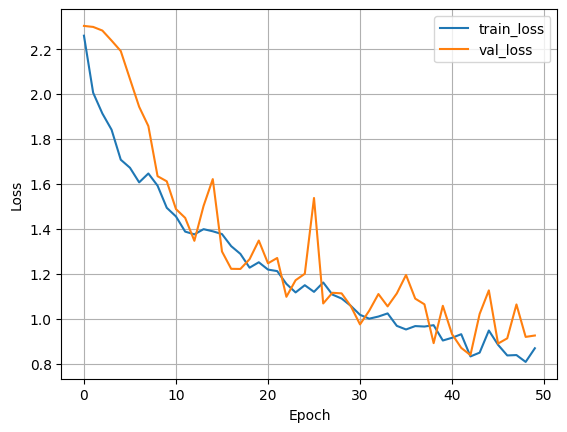

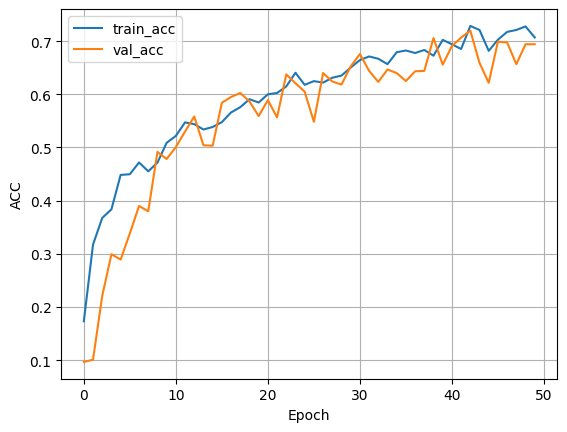

In [14]:
plot_loss_and_acc(log_dir=trainer.logger.log_dir)

In [15]:
trainer.test(dataloaders=datamodule)

/home/onuraydemir/miniconda3/envs/remenv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at ./lightning_logs/simpson_mnist/version_37/checkpoints/epoch=49-step=150.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./lightning_logs/simpson_mnist/version_37/checkpoints/epoch=49-step=150.ckpt
/home/onuraydemir/miniconda3/envs/remenv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `n

Testing DataLoader 0: 100%|███████████████████████| 1/1 [00:00<00:00,  8.16it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.722000002861023     │
│         test_loss         │    0.8923841118812561     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.8923841118812561, 'test_acc': 0.722000002861023}]